# Results analysis

In this notebook we will detail the experiments done on the chosen datasets (Basque and Japanese, both taken from Universal Dependencies) and the obtained results.

## Imports

In [1]:
import math
from collections import defaultdict
from copy import deepcopy
from itertools import pairwise
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
from wordcloud import WordCloud

from dataset_loader import Dataset
from evaluation_metrics import micro_f1, evaluate_dataset
from hmm import HiddenMarkovModel, optimize_unk_threshold

plt.style.use('seaborn-v0_8-bright')

import plotly.io as pio

# Set the plotly theme
pio.templates.default = "plotly_white"

## Load the datasets

In [2]:
# Basque
basque_dataset = Dataset(
    dataset_name='UD_Basque-BDT',
    train_path=Path('../data/UD_Basque-BDT/eu_bdt-ud-train.conllu'),
    dev_path=Path('../data/UD_Basque-BDT/eu_bdt-ud-dev.conllu'),
    test_path=Path('../data/UD_Basque-BDT/eu_bdt-ud-test.conllu'),
)
print('Basque dataset loaded')

basque_lemmatized_dataset = Dataset(
    dataset_name='UD_Basque-BDT',
    train_path=Path('../data/UD_Basque-BDT/eu_bdt-ud-train.conllu'),
    dev_path=Path('../data/UD_Basque-BDT/eu_bdt-ud-dev.conllu'),
    test_path=Path('../data/UD_Basque-BDT/eu_bdt-ud-test.conllu'),
    lemmatized=True
)
print('Lemmatized Basque dataset loaded')

#-------------------------
# Japanese

japanese_dataset = Dataset(
    dataset_name='UD_Japanese-GSD',
    train_path=Path('../data/UD_Japanese-GSD/ja_gsd-ud-train.conllu'),
    dev_path=Path('../data/UD_Japanese-GSD/ja_gsd-ud-dev.conllu'),
    test_path=Path('../data/UD_Japanese-GSD/ja_gsd-ud-test.conllu'),
)
print('Japanese dataset loaded')

japanese_lemmatized_dataset = Dataset(
    dataset_name='UD_Japanese-GSD',
    train_path=Path('../data/UD_Japanese-GSD/ja_gsd-ud-train.conllu'),
    dev_path=Path('../data/UD_Japanese-GSD/ja_gsd-ud-dev.conllu'),
    test_path=Path('../data/UD_Japanese-GSD/ja_gsd-ud-test.conllu'),
    lemmatized=True
)
print('Lemmatized Japanese dataset loaded')

Basque dataset loaded
Lemmatized Basque dataset loaded
Japanese dataset loaded
Lemmatized Japanese dataset loaded


## Hidden Markov Model Training

### Optimize UNK threshold

Don't run this cell, it takes a lot of time to run (+10 mins). The results are already saved in the `unk_thresholds` dictionary.

In [3]:
optimization_params = {
    'min_threshold': 0.00001,
    'max_threshold': 0.0001,
    'num': 250,
}
# Basque
basque_optimization_results = optimize_unk_threshold(basque_dataset, metric_funct=micro_f1, **optimization_params)
basque_lemmatized_optimization_results = optimize_unk_threshold(basque_lemmatized_dataset, metric_funct=micro_f1, **optimization_params)

# Japanese
japanese_optimization_results = optimize_unk_threshold(japanese_dataset, metric_funct=micro_f1, **optimization_params)
japanese_lemmatized_optimization_results = optimize_unk_threshold(japanese_lemmatized_dataset, metric_funct=micro_f1, **optimization_params)

# Print results
print('Basque: ', basque_optimization_results['best_threshold'], basque_optimization_results['best_metric'])
print('Basque lemmatized: ', basque_lemmatized_optimization_results['best_threshold'], basque_lemmatized_optimization_results['best_metric'])
print('Japanese: ', japanese_optimization_results['best_threshold'], japanese_optimization_results['best_metric'])
print('Japanese lemmatized: ', japanese_lemmatized_optimization_results['best_threshold'], japanese_lemmatized_optimization_results['best_metric'])

""" OUTPUT:
Basque:  1.3821725034787874e-05 0.82880265
Basque lemmatized:  1.3821725034787874e-05 0.91803277
Japanese:  1e-05 0.9141369
Japanese lemmatized:  1e-05 0.9351347
"""

100%|██████████| 250/250 [02:27<00:00,  1.70it/s]

Basque:  1.3821725034787874e-05 0.82880265
Basque lemmatized:  1.3821725034787874e-05 0.91803277
Japanese:  1e-05 0.9142183
Japanese lemmatized:  1e-05 0.93521607


' OUTPUT:\nBasque:  1.3821725034787874e-05 0.82880265\nBasque lemmatized:  1.3821725034787874e-05 0.91803277\nJapanese:  1e-05 0.9141369\nJapanese lemmatized:  1e-05 0.9351347\n'

#### Analysis of the optimization results

In [24]:
# Generate a dataframe with the results
optimization_data = []
for value, score in zip(basque_optimization_results['search_space'], basque_optimization_results['results']):
    optimization_data.append({'language': 'basque', 'lemmatized': False, 'threshold': value, 'Micro-F1': score})
for value, score in zip(basque_lemmatized_optimization_results['search_space'], basque_lemmatized_optimization_results['results']):
    optimization_data.append({'language': 'basque', 'lemmatized': True, 'threshold': value, 'Micro-F1': score})
for value, score in zip(japanese_optimization_results['search_space'], japanese_optimization_results['results']):
    optimization_data.append({'language': 'japanese', 'lemmatized': False, 'threshold': value, 'Micro-F1': score})
for value, score in zip(japanese_lemmatized_optimization_results['search_space'], japanese_lemmatized_optimization_results['results']):
    optimization_data.append({'language': 'japanese', 'lemmatized': True, 'threshold': value, 'Micro-F1': score})

optimization_df = pd.DataFrame(optimization_data)

# Plot the results
fig = px.line(optimization_df, x='threshold', y='Micro-F1', color='language', line_dash='lemmatized', log_x=True)
fig.show()

As anticipated, the models’ performance show a notable decline with increasing thresholds, attributed to the greater substitution of words by the UNK token, resulting in identical emission probabilities in those cases.

Analysis of both lemmatized and non-lemmatized datasets reveals an interesting similarity in the optimal thresholds for performance. However, distinct behavior is observed between the Basque and Japanese datasets. Models trained on Japanese datasets demonstrate optimal performance with lower thresholds, exhibiting a decline in performance as the threshold increases. Conversely, those trained on Basque datasets showcase remarkably low performance at lower thresholds until a significant upturn occurs at a threshold of 1e-5, after which their performance reaches its peak. Subsequently, the performance gradually decreases with further increments in the threshold value.



In [5]:
# Optimization best thresholds
unk_thresholds = {
    'basque': 1.3821725034787874e-05,
    'basque_lemmatized': 1.3821725034787874e-05,
    'japanese': 1e-05,
    'japanese_lemmatized': 1e-05
}

## Train the final models

In [6]:
# Basque models
basque_hmm = HiddenMarkovModel(basque_dataset, unknown_token_threshold=unk_thresholds['basque'])
basque_lemmatized_hmm = HiddenMarkovModel(basque_lemmatized_dataset, unknown_token_threshold=unk_thresholds['basque_lemmatized'])

# Japanese models
japanese_hmm = HiddenMarkovModel(japanese_dataset, unknown_token_threshold=unk_thresholds['japanese'])
japanese_lemmatized_hmm = HiddenMarkovModel(japanese_lemmatized_dataset, unknown_token_threshold=unk_thresholds['japanese_lemmatized'])

## Performance Evaluation

### Predictions

In [7]:
# Basque
basque_predictions = basque_hmm.batch_predict(basque_dataset.test)
basque_lemmatized_predictions = basque_lemmatized_hmm.batch_predict(basque_lemmatized_dataset.test)

# Japanese
japanese_predictions = japanese_hmm.batch_predict(japanese_dataset.test)
japanese_lemmatized_predictions = japanese_lemmatized_hmm.batch_predict(japanese_lemmatized_dataset.test)

### Evaluation

In [8]:
eval_metrics_basque = evaluate_dataset(basque_dataset.test.data, basque_predictions[0], basque_predictions[1])
eval_metrics_basque_lemmatized = evaluate_dataset(basque_lemmatized_dataset.test.data, basque_lemmatized_predictions[0], basque_lemmatized_predictions[1])

eval_metrics_japanese = evaluate_dataset(japanese_dataset.test.data, japanese_predictions[0], japanese_predictions[1])
eval_metrics_japanese_lemmatized = evaluate_dataset(japanese_lemmatized_dataset.test.data, japanese_lemmatized_predictions[0], japanese_lemmatized_predictions[1])

#### Convert the evaluation metrics to a dataframe

In [25]:
df_rows = []
df_per_tag_rows = []


def postprocess_metric_dict(metric_keys: list[str], metric_dict, language, lemmatized, postprocess_rows, postprocess_per_tag_rows):
    for _sub_key, _value in metric_dict.items():
        if _sub_key == 'per_sentence':
            continue
        elif _sub_key == 'per_tag':
            postprocess_metric_dict(metric_keys + [_sub_key], _value, language, lemmatized, postprocess_per_tag_rows, None)
        elif isinstance(_value, dict):
            postprocess_metric_dict(metric_keys + [_sub_key], _value, language, lemmatized, postprocess_rows, postprocess_per_tag_rows)
        else:
            postprocess_rows.append({
                'Metric': '-'.join(metric_keys + [_sub_key]),
                'Language': language,
                'Lemmatized': lemmatized,
                'Score': _value
            })


postprocess_metric_dict([], eval_metrics_basque, 'Basque', False, df_rows, df_per_tag_rows)
postprocess_metric_dict([], eval_metrics_basque_lemmatized, 'Basque', True, df_rows, df_per_tag_rows)
postprocess_metric_dict([], eval_metrics_japanese, 'Japanese', False, df_rows, df_per_tag_rows)
postprocess_metric_dict([], eval_metrics_japanese_lemmatized, 'Japanese', True, df_rows, df_per_tag_rows)

eval_metrics_df = pd.DataFrame(df_rows)

## Evaluation Result Analysis

### Basic Metrics

In [26]:
eval_metrics_df_ = eval_metrics_df[eval_metrics_df['Metric'] != 'perplexity']
fig = px.bar(eval_metrics_df_, x='Metric', y='Score', color='Language', pattern_shape='Lemmatized', barmode='group', range_y=[0.55, 1.])
fig.show()

The bar plot illustrates model evaluation metrics for both lemmatized and non-lemmatized data, revealing a significant enhancement in the model's performance when utilizing lemmatized data. Nevertheless, in the context of the Japanese dataset compared to the Basque dataset, the performance gap between lemmatized and non-lemmatized data is narrower.

The superior performance of the Japanese models compared to the Basque models can be attributed to the larger volume of training data available in the Japanese corpus. Not only does the Japanese corpus contain 1,700 more instances, but each instance also comprises a higher overall token count, as evidenced by the data exploration.

It's worth noting that although both languages share common linguistic features such as being agglutinative and head-final, they diverge significantly in their grammatical structure. For instance, Japanese utilizes particles that function independently of nouns, whereas Basque exhibits noun inflection. An illustrative case can be seen in the dative case representation (e.g., "to me"):
- In Basque: "Ni" transforms to "Niri." 
- In Japanese: "Watashi" (私) changes to "Watashi ni" (私に).

This linguistic distinction results in Japanese words consistently appearing in the same form, while in Basque, the same word can manifest in various forms. This discrepancy explains the substantial improvement observed when lemmatizing Basque, as opposed to the less pronounced effect in the case of Japanese. The structural differences in how these languages handle word forms significantly impact the outcomes of tokenization and lemmatization and thus the models’ performance.


### Evaluation based on the length of the sentences

In [27]:


# Basque evaluation based on the length of the sentences
_datasets = [
    {'language': 'basque', 'lemmatized': False, 'dataset': deepcopy(eval_metrics_basque['per_sentence']), 'sentences': defaultdict(list)},
    {'language': 'basque', 'lemmatized': True, 'dataset': deepcopy(eval_metrics_basque_lemmatized['per_sentence']), 'sentences': defaultdict(list)},
    {'language': 'japanese', 'lemmatized': False, 'dataset': deepcopy(eval_metrics_japanese['per_sentence']), 'sentences': defaultdict(list)},
    {'language': 'japanese', 'lemmatized': True, 'dataset': deepcopy(eval_metrics_japanese_lemmatized['per_sentence']), 'sentences': defaultdict(list)},
]

# flatten dict
for dataset in _datasets:
    sentences = dataset['sentences']
    dataset = dataset['dataset']
    for instance in dataset:
        sentences[instance['length']].append(instance['sentence'])
        del instance['sentence']
        del instance['per_tag']
        for key, value in list(instance.items()):
            if isinstance(value, dict):
                for k, v in value.items():
                    instance[f'{key}-{k}'] = v
                del instance[key]

_dfs = []
for dataset in _datasets:
    _df = pd.DataFrame(dataset['dataset'])
    _df['Language'] = dataset['language']
    _df['Lemmatized'] = dataset['lemmatized']
    _dfs.append(_df)
df = pd.concat(_dfs)

# Group by length
df = df.groupby(['length', 'Lemmatized', 'Language']).agg(['mean', 'std']).reset_index()
df.columns = [f'{col[0]}-{col[1]}' if col[1] else col[0] for col in df.columns if len(col) > 1]

In [28]:
fig = px.line(
    data_frame=df,
    x='length', y='accuracy-mean',
    line_dash='Lemmatized',
    color='Language',
    facet_row='Language',
)
fig.show()

In [13]:
from pprint import pprint

# Get the Basque predictions for length 3 sentences
pprint(list(zip(_datasets[0]['sentences'][3], _datasets[1]['sentences'][3])))

[('Zer egin ?', 'zer egin ?'),
 ('Zer egin ?', 'zer egin ?'),
 ('Zeu zara !', 'zeu izan !'),
 ('Urrutiegi zeuden .', 'urruti egon .'),
 ('Bukatua da !', 'bukatu izan !'),
 ('Asetu da .', 'ase izan .'),
 ('Polita litzateke :', 'polit izan :'),
 ('Zaude lasai .', 'egon lasai .'),
 ('Zer egin ?', 'zer egin ?'),
 ('Erranen dautzuet .', 'erran edun .'),
 ('Harriturik nago .', 'harritu egon .'),
 ('Bota ezan .', 'botatu ezan .')]


There is limited evidence to suggest that the text's length significantly impacts the model's performance. Variances observed in lengthy documents, as evident in the Japanese case, can be attributed to the scarcity of instances of that particular length, thereby being influenced by the unique characteristics of those instances

However, a notable distinction emerges between the non-lemmatized and lemmatized versions of Basque when considering sentences of three tokens in length ( examples provided above). This occurrence is mostly associated with the previously mentioned issue concerning Basque inflections. It is also directly linked to the emission probability of each token, as the transition probabilities should theoretically remain equal for both the non-lemmatized and lemmatized versions.

### Error analysis

#### Confusion matrix

In [14]:
def get_confusion_matrix_plots(dataset, predictions, dataset_name, lemmatized):
    _pos_tags = set([tag for sentence in dataset.test.data for _, tag in sentence])
    _confusion_matrix = pd.DataFrame(
        data=0,
        index=list(_pos_tags),
        columns=list(_pos_tags),
    )
    _gold_tags = [tag for sentence in dataset.test.data for _, tag in sentence]
    _pred_tags = [tag for sentence in predictions[0] for _, tag in sentence]
    for _gold, _pred in zip(_gold_tags, _pred_tags):
        _confusion_matrix[_gold][_pred] += 1
    # Normalize
    _confusion_matrix_norm = _confusion_matrix.div(_confusion_matrix.sum(axis=0), axis=1).fillna(0).mul(100).round(1)

    # Generate the confusion matrix plots
    confusion_matrix_heatmap = px.imshow(
        img=_confusion_matrix,
        text_auto=True,
        aspect="auto",
        labels={
            'x': "Gold tag",
            'y': "Predicted tag",
            'color': "Freq"
        },
        title=f"Confusion matrix for {dataset_name} {'lemmatized' if lemmatized else 'non-lemmatized'} dataset"
    )
    confusion_matrix_heatmap.update_xaxes(tickangle=45)

    confusion_matrix_heatmap_norm = px.imshow(
        img=_confusion_matrix_norm,
        text_auto=True,
        aspect="auto",
        labels={
            'x': "Gold tag",
            'y': "Predicted tag",
            'color': "Freq"
        },
        title=f"Confusion matrix for {dataset_name} {'lemmatized' if lemmatized else 'non-lemmatized'} dataset (normalized)"
    )
    confusion_matrix_heatmap_norm.update_xaxes(tickangle=45)

    return confusion_matrix_heatmap, confusion_matrix_heatmap_norm


# Generate the confusion matrix plots
# Basque
basque_confusion_matrix_heatmap, basque_confusion_matrix_norm = get_confusion_matrix_plots(basque_dataset, basque_predictions, 'Basque', False)
basque_lemmatized_confusion_matrix_heatmap, basque_lemmatized_confusion_matrix_norm = get_confusion_matrix_plots(basque_lemmatized_dataset, basque_lemmatized_predictions, 'Basque', True)
# Japanese
japanese_confusion_matrix_heatmap, japanese_confusion_matrix_norm = get_confusion_matrix_plots(japanese_dataset, japanese_predictions, 'Japanese', False)
japanese_lemmatized_confusion_matrix_heatmap, japanese_lemmatized_confusion_matrix_norm = get_confusion_matrix_plots(japanese_lemmatized_dataset, japanese_lemmatized_predictions, 'Japanese', True)

# Print confusion matrix in grid subplots
fig = make_subplots(1, 2, horizontal_spacing=0.1)
fig.add_trace(basque_confusion_matrix_heatmap.data[0], row=1, col=1)
fig.add_trace(basque_lemmatized_confusion_matrix_heatmap.data[0], row=1, col=2)
fig.update_layout(title_text="Basque non-lemmatized vs lemmatized")
fig.update_yaxes(title_text="Prediction", row=1, col=1)
fig.update_yaxes(title_text="Prediction", row=1, col=2)
fig.update_xaxes(title_text="Gold", row=1, col=1)
fig.update_xaxes(title_text="Gold", row=1, col=2)
fig.show()

fig = make_subplots(1, 2, horizontal_spacing=0.1)
fig.add_trace(japanese_confusion_matrix_heatmap.data[0], row=1, col=1)
fig.add_trace(japanese_lemmatized_confusion_matrix_heatmap.data[0], row=1, col=2)
fig.update_layout(title_text="Japanese non-lemmatized vs lemmatized")
fig.update_yaxes(title_text="Prediction", row=1, col=1)
fig.update_yaxes(title_text="Prediction", row=1, col=2)
fig.update_xaxes(title_text="Gold", row=1, col=1)
fig.update_xaxes(title_text="Gold", row=1, col=2)
fig.show()

# Print normalized confusion matrix in grid subplots
fig = make_subplots(1, 2, horizontal_spacing=0.1)
fig.add_trace(basque_confusion_matrix_norm.data[0], row=1, col=1)
fig.add_trace(basque_lemmatized_confusion_matrix_norm.data[0], row=1, col=2)
fig.update_layout(title_text="Basque non-lemmatized vs lemmatized (normalized)")
fig.update_yaxes(title_text="Prediction", row=1, col=1)
fig.update_yaxes(title_text="Prediction", row=1, col=2)
fig.update_xaxes(title_text="Gold", row=1, col=1)
fig.update_xaxes(title_text="Gold", row=1, col=2)
fig.show()

fig = make_subplots(1, 2, horizontal_spacing=0.1)
fig.add_trace(japanese_confusion_matrix_norm.data[0], row=1, col=1)
fig.add_trace(japanese_lemmatized_confusion_matrix_norm.data[0], row=1, col=2)
fig.update_layout(title_text="Japanese non-lemmatized vs lemmatized (normalized)")
fig.update_yaxes(title_text="Prediction", row=1, col=1)
fig.update_yaxes(title_text="Prediction", row=1, col=2)
fig.update_xaxes(title_text="Gold", row=1, col=1)
fig.update_xaxes(title_text="Gold", row=1, col=2)
fig.show()

An in-depth analysis of our PoS tagging models applied to the Basque dataset reveals a notable level of accuracy across the majority of tags, as evidenced by the prevalence of yellow shades along the diagonal line, signifying close alignment with the gold standard predictions. However, our model, applied to the non-lemmatized dataset, encounters specific challenges, such as mislabeling INTJ as PROPN, PROPNs as NOUNs, or tokens classified as X mistakenly predicted as ADV. Notably, this model tends to exhibit a tendency to overclassify tokens as NOUN or PROPN.

In contrast, the model trained on the lemmatized dataset demonstrates superior performance compared to its non-lemmatized counterpart, evidenced by a reduced number of instances positioned outside the diagonal. This improvement signifies more accurate predictions. These findings correlate with the Basic Metrics bar chart, reinforcing our earlier discussion regarding the expected superiority of the lemmatized data model given the characteristics of the Basque language. Although this version also displays a tendency to overclassify tokens as NOUN or PROPN, the occurrence is notably reduced compared to the non-lemmatized model.

Upon analysis of the predictions from models trained on the Japanese dataset, both the lemmatized and non-lemmatized models excel at the PoS tagging task. However, there exist instances where proper nouns (PROPNs) are inaccurately labeled as NOUNs, and certain particles (PART) are erroneously identified as AUX, among other infrequent errors. Although not immediately evident, after closer examination, it can be noticed that the model trained on lemmatized data performs slightly better. This conclusion aligns with the findings indicated in the Basic Metrics chart, suggesting a marginal superiority of the lemmatized data model over its non-lemmatized counterpart.

Notably, the chosen Japanese dataset lacks tokens labeled as INTJ, resulting in infrequent annotations of tokens with this specific tag by the models. Concerning the INTJ tag, while the non-lemmatized version consistently classifies all instances as VERB, the lemmatized model tends to classify them as NOUN.


#### Bigram Error Rates

In [15]:
def get_bigram_error_df(dataset, predictions):
    _pos_tags = set([tag for sentence in dataset.test.data for _, tag in sentence])
    _failed_tag_bigrams_df = pd.DataFrame(
        data=0,
        index=['<BEGIN>'] + list(_pos_tags),
        columns=list(_pos_tags) + ['<END>'],
    )
    _tag_bigrams_apparitions_df = pd.DataFrame(
        data=0,
        index=['<BEGIN>'] + list(_pos_tags),
        columns=list(_pos_tags) + ['<END>'],
    )
    _gold_bigrams = [(tag_1, tag_2) for sentence in dataset.test.data for (_, tag_1), (_, tag_2) in pairwise([(None, '<BEGIN>')] + sentence + [(None, '<END>')])]
    _pred_bigrams = [(tag_1, tag_2) for sentence in predictions[0] for (_, tag_1), (_, tag_2) in pairwise([(None, '<BEGIN>')] + sentence + [(None, '<END>')])]
    for _gold, _pred in zip(_gold_bigrams, _pred_bigrams):
        _tag_bigrams_apparitions_df[_gold[1]][_gold[0]] += 1
        if _gold != _pred:
            _failed_tag_bigrams_df[_gold[1]][_gold[0]] += 1
    # Normalize
    _failed_tag_bigrams_df_norm = _failed_tag_bigrams_df.div(_tag_bigrams_apparitions_df).fillna(0)

    return _failed_tag_bigrams_df, _failed_tag_bigrams_df_norm.mul(100).round(1)


def generate_error_matrix_plot(bigram_error_df, bigram_error_df_norm, language, lemmatized):
    bigram_errors_heatmap = px.imshow(
        img=bigram_error_df,
        text_auto=True,
        aspect="auto",
        labels={
            'x': "Second tag",
            'y': "First tag",
            'color': "Bigram Freq"
        },
        title=f"Number of failed tag bigrams in {language} {'lemmatized' if lemmatized else 'non-lemmatized'} dataset",
        color_continuous_scale='blues'
    )

    bigram_errors_norm_heatmap = px.imshow(
        img=bigram_error_df_norm,
        text_auto=True,
        aspect="auto",
        labels={
            'x': "Second tag",
            'y': "First tag",
            'color': "Bigram Freq"
        },
        title="Number of failed tag bigrams in {language} {'lemmatized' if lemmatized else 'non-lemmatized'} dataset normalized by tag bigram apparitions",
        color_continuous_scale='blues'
    )

    return bigram_errors_heatmap, bigram_errors_norm_heatmap

In [16]:
# Generate dataframes
# Basque
basque_failed_tag_bigrams_df, basque_failed_tag_bigrams_df_norm = get_bigram_error_df(basque_dataset, basque_predictions)
basque_lemmatized_failed_tag_bigrams_df, basque_lemmatized_failed_tag_bigrams_df_norm = get_bigram_error_df(basque_dataset, basque_lemmatized_predictions)
# Japanese
japanese_failed_tag_bigrams_df, japanese_failed_tag_bigrams_df_norm = get_bigram_error_df(japanese_dataset, japanese_predictions)
japanese_lemmatized_failed_tag_bigrams_df, japanese_lemmatized_failed_tag_bigrams_df_norm = get_bigram_error_df(japanese_dataset, japanese_lemmatized_predictions)

# Generate the error matrix plots
basque_failed_tag_bigrams_heatmap, basque_failed_tag_bigrams_norm_heatmap = generate_error_matrix_plot(basque_failed_tag_bigrams_df, basque_failed_tag_bigrams_df_norm, 'Basque', False)
basque_lemmatized_failed_tag_bigrams_heatmap, basque_lemmatized_failed_tag_bigrams_norm_heatmap = generate_error_matrix_plot(basque_lemmatized_failed_tag_bigrams_df, basque_lemmatized_failed_tag_bigrams_df_norm, 'Basque', True)
japanese_failed_tag_bigrams_heatmap, japanese_failed_tag_bigrams_norm_heatmap = generate_error_matrix_plot(japanese_failed_tag_bigrams_df, japanese_failed_tag_bigrams_df_norm, 'Japanese', False)
japanese_lemmatized_failed_tag_bigrams_heatmap, japanese_lemmatized_failed_tag_bigrams_norm_heatmap = generate_error_matrix_plot(japanese_lemmatized_failed_tag_bigrams_df, japanese_lemmatized_failed_tag_bigrams_df_norm, 'Japanese', True)

# Plot in grid subplots
fig = make_subplots(1, 2, horizontal_spacing=0.1)
fig.add_trace(basque_failed_tag_bigrams_heatmap.data[0], row=1, col=1)
fig.add_trace(basque_lemmatized_failed_tag_bigrams_heatmap.data[0], row=1, col=2)
fig.update_layout(title_text="Basque non-lemmatized vs lemmatized (not normalized)", coloraxis=dict(colorscale='blues'))
fig.update_yaxes(title_text="First Tag", row=1, col=1)
fig.update_yaxes(title_text="First Tag", row=1, col=2)
fig.update_xaxes(title_text="Second Tag", row=1, col=1)
fig.update_xaxes(title_text="Second Tag", row=1, col=2)
fig.show()

fig = make_subplots(1, 2, horizontal_spacing=0.1)
fig.add_trace(japanese_failed_tag_bigrams_heatmap.data[0], row=1, col=1)
fig.add_trace(japanese_lemmatized_failed_tag_bigrams_heatmap.data[0], row=1, col=2)
fig.update_layout(title_text="Japanese non-lemmatized vs lemmatized (not normalized)", coloraxis=dict(colorscale='blues'))
fig.update_yaxes(title_text="First Tag", row=1, col=1)
fig.update_yaxes(title_text="First Tag", row=1, col=2)
fig.update_xaxes(title_text="Second Tag", row=1, col=1)
fig.update_xaxes(title_text="Second Tag", row=1, col=2)
fig.show()


fig = make_subplots(1, 2, horizontal_spacing=0.1)
fig.add_trace(basque_failed_tag_bigrams_norm_heatmap.data[0], row=1, col=1)
fig.add_trace(basque_lemmatized_failed_tag_bigrams_norm_heatmap.data[0], row=1, col=2)
fig.update_layout(title_text="Basque non-lemmatized vs lemmatized (normalized)", coloraxis=dict(colorscale='blues'))
fig.update_yaxes(title_text="First Tag", row=1, col=1)
fig.update_yaxes(title_text="First Tag", row=1, col=2)
fig.update_xaxes(title_text="Second Tag", row=1, col=1)
fig.update_xaxes(title_text="Second Tag", row=1, col=2)
fig.show()

fig = make_subplots(1, 2, horizontal_spacing=0.1)
fig.add_trace(japanese_failed_tag_bigrams_norm_heatmap.data[0], row=1, col=1)
fig.add_trace(japanese_lemmatized_failed_tag_bigrams_norm_heatmap.data[0], row=1, col=2)
fig.update_layout(title_text="Japanese non-lemmatized vs lemmatized (normalized)", coloraxis=dict(colorscale='blues'))
fig.update_yaxes(title_text="First Tag", row=1, col=1)
fig.update_yaxes(title_text="First Tag", row=1, col=2)
fig.update_xaxes(title_text="Second Tag", row=1, col=1)
fig.update_xaxes(title_text="Second Tag", row=1, col=2)
fig.show()

The heatmaps visually display instances where the models inaccurately classified pairs of tags (bigrams). The y-axis represents the first token of the bigram, while the x-axis indicates the second token of the bigram. 

Upon reviewing the counts for Basque, it's evident that bigrams containing a NOUN in either position exhibit the highest absolute error rates, particularly (NOUN, NOUN), (NOUN, ADJ), and (NOUN, VERB). However, normalizing the error counts based on the occurrence rate of each bigram yields a notable shift in the matrix, highlighting higher relative errors overall. These higher relative errors are primarily due to the infrequency of those specific bigrams. Notably, the three pairs with the highest error counts demonstrate relatively low error rates when normalized.

Both models, whether trained on non-lemmatized or lemmatized data, exhibit similar error distributions. However, as previously discussed, the lemmatized version displays fewer errors overall.


In Japanese, both the lemmatized and non-lemmatized versions exhibit minimal discrepancies in the errors they make, and notably possess lower error rates compared to the Basque models. The tuples with the highest error counts are (NOUN, NOUN), (ADP, VERB), and (ADP, NOUN). Similar to the Basque results, when these errors are normalized, their severity diminishes.


#### Word Error Analysis

The following tables and word-clouds show how many times a word has been confused, together with its correct label and the label it has been mistaken with.

In [17]:
def get_word_error_df(_dataset, predictions):
    errors_word = list()

    for gold_sentence, pred_sentence in zip(_dataset.test.data, predictions[0]):
        sentence = ' '.join([word[0] for word in gold_sentence])
        errors = 0
        for gold, pred in zip(gold_sentence, pred_sentence):
            if not gold[1] == pred[1]:
                errors_word.append((gold[0], gold[1], pred[1], sentence, 1))

    # Group and add counts
    errors_df = pd.DataFrame(errors_word, columns=['Word', 'Gold POS tag', 'Predicted POS tag', 'Sentences', 'Count']).groupby(['Word', 'Gold POS tag', 'Predicted POS tag']).agg({'Count': 'count', 'Sentences': lambda x: list(x), }).reset_index()
    # Order by count
    errors_df = errors_df.sort_values(by='Count', ascending=False)
    return errors_df


def plot_error_wordcloud(error_word_df, title, min_freq=1, min_words=5, jp_font=False):
    # Generate the figure
    plt.rcParams['figure.figsize'] = [20, 10]

    # Generate the wordclouds
    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)

    font = None if not jp_font else './fonts/NotoSansJP-Medium.ttf'
    wordcloud = WordCloud(font_path=font, background_color="white", mask=mask, contour_width=0.1,
                          contour_color="black", max_font_size=150, random_state=42
                          , colormap='RdYlGn')

    gold_tags = error_word_df['Gold POS tag'].unique()
    pred_tags = error_word_df['Predicted POS tag'].unique()

    word_freqs = dict()

    # Filter low frequency words
    error_word_df_ = error_word_df[error_word_df['Count'] > min_freq]

    # Add the wordclouds to the figure
    for i, gold_tag in enumerate(gold_tags):
        for j, pred_tag in enumerate(pred_tags):
            # Generate the dictionary of frequencies for each pair
            _words = error_word_df_[(error_word_df_['Gold POS tag'] == gold_tag) & (error_word_df_['Predicted POS tag'] == pred_tag)]['Word'].tolist()
            _frequencies = error_word_df_[(error_word_df_['Gold POS tag'] == gold_tag) & (error_word_df_['Predicted POS tag'] == pred_tag)]['Count'].tolist()
            frequencies = {word: frequency for word, frequency in zip(_words, _frequencies)}

            if len(frequencies) < min_words:
                continue
            else:
                word_freqs[(gold_tag, pred_tag)] = frequencies

    for i, ((gold_tag, pred_tag), frequencies) in enumerate(word_freqs.items(), start=1):
        # Generate the wordcloud
        wordcloud.generate_from_frequencies(frequencies)

        # Add the wordcloud to the figure
        ax = plt.subplot(math.ceil(len(word_freqs) / 4), 4, i)
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.set_title(f'{gold_tag} -> {pred_tag}')
        ax.axis("off")

    # Set the title 
    plt.suptitle(title, fontsize=20)

    plt.show()

In [18]:
# Basque
basque_word_errors_df = get_word_error_df(basque_dataset, basque_predictions)
basque_lemmatized_word_errors_df = get_word_error_df(basque_lemmatized_dataset, basque_lemmatized_predictions)
# Japanese
japanese_word_errors_df = get_word_error_df(japanese_dataset, japanese_predictions)
japanese_lemmatized_word_errors_df = get_word_error_df(japanese_lemmatized_dataset, japanese_lemmatized_predictions)

In [19]:
# Print the word error dataframes
print('Basque non-lemmatized')
display(basque_word_errors_df)
print('Basque lemmatized')
display(basque_lemmatized_word_errors_df)
print('Japanese non-lemmatized')
display(japanese_word_errors_df)
print('Japanese lemmatized')
display(japanese_lemmatized_word_errors_df)

Basque non-lemmatized


,Word,Gold POS tag,Predicted POS tag,Count,Sentences
2570,izan,AUX,VERB,86,[Gobernuko oinarri nagusietarik izan den Marti...
1723,da,VERB,AUX,52,[Dakidan bakarra da taldeak bizi duen egoera p...
1871,du,VERB,AUX,31,"["" Baina , ETAk EAJ ordezkatu nahi du ., Horre..."
1888,dute,VERB,AUX,20,"[Azken bilera apirilaren 4an egin zuten , eta ..."
1826,dira,VERB,AUX,19,"[- Gune ez hiritarretan bizi dira nagusiki ., ..."
...,...,...,...,...,...
1182,Ureztatzerakoan,VERB,PROPN,1,[- Ureztatzerakoan hostoak ez busti .]
1183,Urretxun,PROPN,NOUN,1,[Urretxun jaio zen 1820an .]
1184,Urrezko,ADJ,NOUN,1,[Urrezko bost domina leporatzea zen bere erron...
1185,Urrezko,ADJ,PROPN,1,"[Urrezko pibe-a kardiologo , nutrizionista eta..."


Basque lemmatized


,Word,Gold POS tag,Predicted POS tag,Count,Sentences
922,izan,AUX,VERB,154,"[lehen sari 50.000 pezeta izan izan , bigarren..."
923,izan,VERB,AUX,149,"[- gune ez hiritar bizi izan nagusiki ., jakin..."
609,egon,AUX,VERB,38,"[baikor egon , dena alde izan edun uste ukan ""..."
610,egon,VERB,AUX,31,[arazo izan ez egon instituzio arau horiek bet...
1317,ukan,AUX,VERB,26,"[- kanguru egon , hortxe ukan Don Meliton pres..."
...,...,...,...,...,...
473,baiezko,NOUN,ADJ,1,[( harro baiezko egin .]
472,badia,NOUN,PROPN,1,"[badia begira jarraitu edun , faro kliska tart..."
471,baby,NOUN,PROPN,1,[poor baby jazz tankera musika talde buru ukan...
470,aztoratu,VERB,NOUN,1,[kazetari aztoratu ibili izan atzo Euskadi fun...


Japanese non-lemmatized


,Word,Gold POS tag,Predicted POS tag,Count,Sentences
142,で,AUX,ADP,73,"[バームクーヘン で も 周り に お 砂糖 が たっぷり 付い て いる もの 。, Ad..."
153,と,ADP,SCONJ,63,"[幸福 の 科学 側 から は , 特に どう し て ほしい と いう 要望 は いただい..."
180,に,AUX,ADP,56,"[そう だっ たら いい なあ と は 思い ます が , 日本 学術 会議 の 会長 談話..."
104,し,AUX,VERB,27,"[幸福 の 科学 側 から は , 特に どう し て ほしい と いう 要望 は いただい..."
98,さ,PART,AUX,15,"[室長 の 対応 に は 終始 誠実 さ が 感じ られ た 。, 昔 , 阪神 淡路 大 ..."
...,...,...,...,...,...
301,フィッシング,NOUN,PROPN,1,[また 、 攻撃 手法 と し て は Java Script の 難読 化 に よる 手口...
302,フラフラ,ADJ,NOUN,1,[仕事 に 疲れ て フラフラ で チェック イン し て も 、 フロント の 方 を は...
303,フリー,ADJ,NOUN,1,[相手 GK と 1 対 1 に なっ たり だ と か 、 完全 に フリー で シュート...
304,フレア,NOUN,PROPN,1,[一般 的 に ハニー ・ ライトニング ・ フレア より 威力 が 高い 。]


Japanese lemmatized


,Word,Gold POS tag,Predicted POS tag,Count,Sentences
78,と,ADP,SCONJ,66,"[幸福 の 科学 側 から は , 特に どう 為る て 欲しい と 言う 要望 は 頂く ..."
434,為る,AUX,VERB,27,"[幸福 の 科学 側 から は , 特に どう 為る て 欲しい と 言う 要望 は 頂く ..."
437,為る,VERB,AUX,16,"[当選 為る て 市長 に 成る て も 猶 , 摂理 と の 関係 を 明らか だ 為る ..."
84,に,SCONJ,ADP,13,[18 分 以降 、 SAGAWA が ボール を キープ 為る 時間 が 増える 出す 行...
438,無い,ADJ,AUX,12,[唯 、 此の 質問 に 対する 回答 は 、 誰 か に 回答 が 固まる 事 無い 、 ...
...,...,...,...,...,...
212,二三,NUM,NOUN,1,[此の 為 先 に 派遣 為る れる て 居る た 2 個 偵察 機 隊 に 加える 、 新...
211,事実,ADV,NOUN,1,[駐車 場 は 有る 物 の 立体 駐車 場 で 出入り に 時間 が 掛かる 、 6 号 ...
210,事変,NOUN,PROPN,1,[此の 為 先 に 派遣 為る れる て 居る た 2 個 偵察 機 隊 に 加える 、 新...
209,予約,NOUN,VERB,1,[診察 は 予約 制 だ の に 1 時間 待ち は ざら です 。]


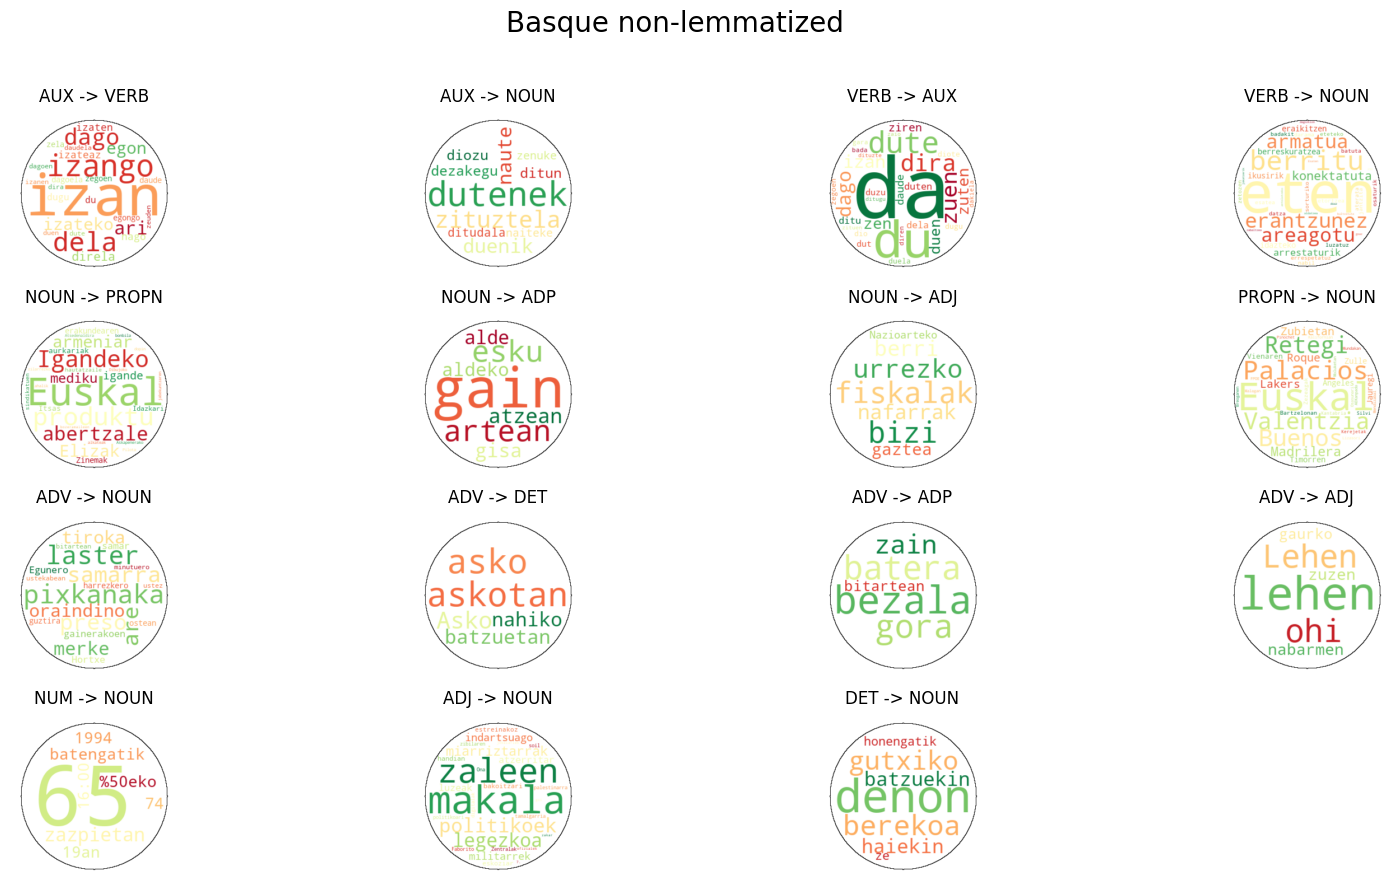

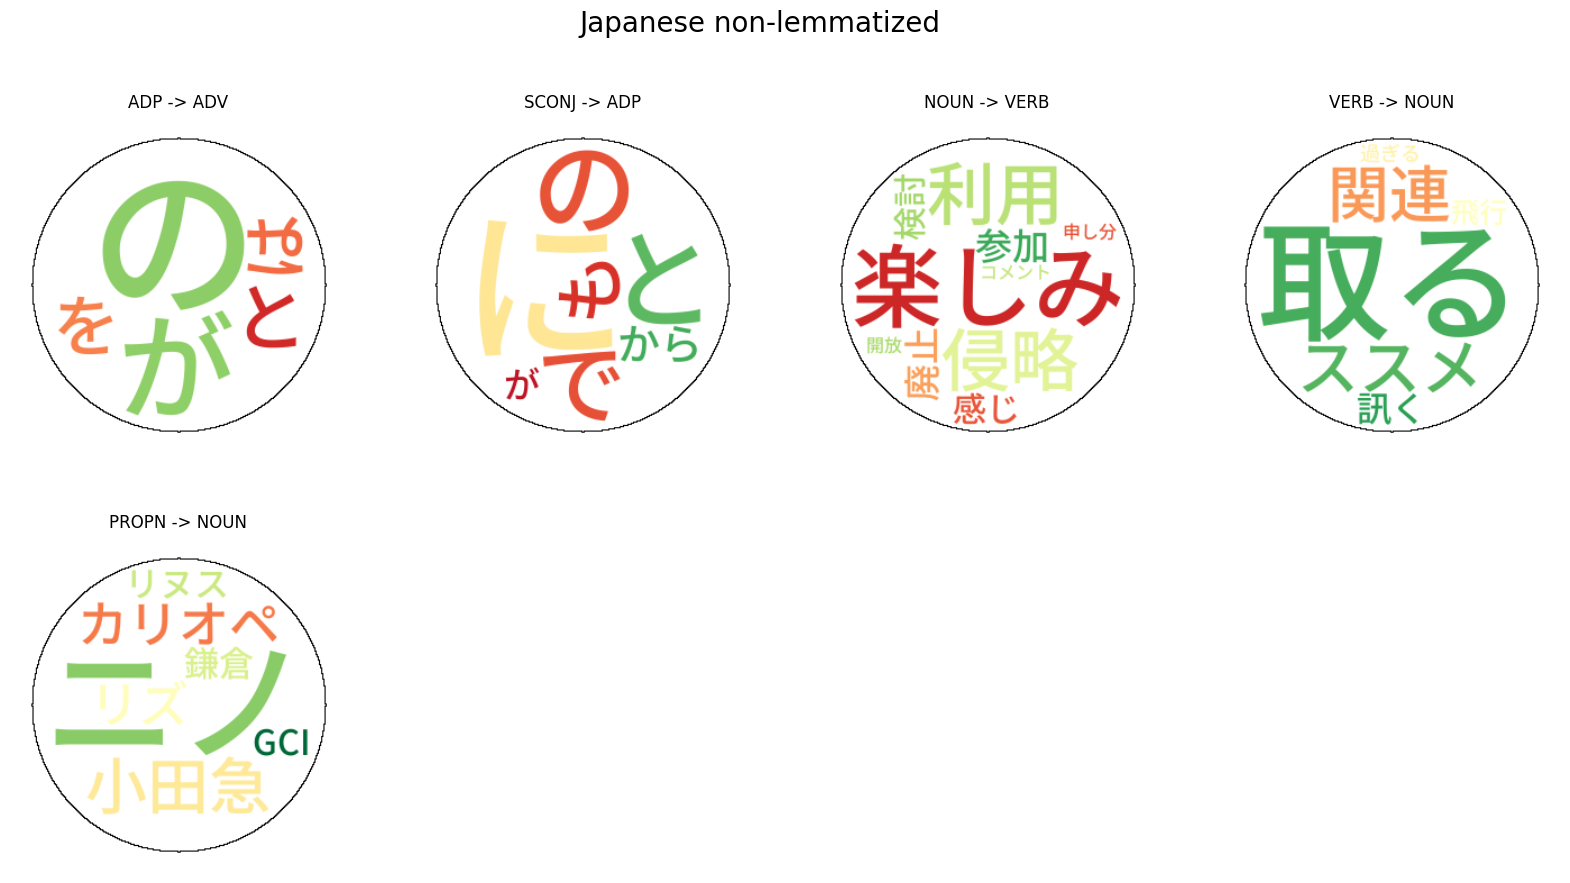

In [20]:
# Generate the wordclouds
plot_error_wordcloud(basque_word_errors_df, 'Basque non-lemmatized')
# plot_error_wordcloud(basque_lemmatized_word_errors_df, 'Basque lemmatized')
plot_error_wordcloud(japanese_word_errors_df, 'Japanese non-lemmatized', jp_font=True)
# plot_error_wordcloud(japanese_lemmatized_word_errors_df, 'Japanese lemmatized', jp_font=True)

##### Basque

When analyzing the errors made in the Basque model, we can observe that the majority of mistakes are attributed to the multiple functions of words. In Basque, many words can assume different syntactic roles, thus resulting in varied annotations for the same word in different contexts. Some of these cases are explained in greater detail below:

- NOUN -> ADJ: It is something that does not happen very often according to the confusion matrix of the model trained on the non-lemmatized Basque dataset (45 times). This may have happened because the dataset contains more times the word bizi as an ADJ rather than a noun.
    - NOUN: Ehun urteko bizi zoriontsua izan du.
    - ADJ: Pertsona bizi eta alaia da.
- PROPN -> NOUN: In the case of the proper nouns (PROPN), it is not unusual that they are mistaken with common nouns (NOUN). Both tags are used in the same exact context and follow the same syntactic rules, but it is less common to find multiple occurrences of the same proper noun than it is to find a common one, so the probability for a word to be cataloged as a common noun is a lot bigger.
    - PROPN: Lorea etorri da.
    - NOUN: Lorea gorria da.
- NOUN->PROPN: Even though there are a lot less proper names than common, there is also the contrary case of mistaking a common noun with a proper one. In Basque, it is usual to find, for example, person names that make reference to objects or natural elements or phenomena (such as Lorea, Jauregi,...), so there will be the case of having the same word with both NOUN and PROPN tags in different contexts. However, in this dataset most of the proper names come from other languages, mostly from English or Spanish, so in this case the error is more due to the lack of repeated occurrences of proper names.
    - NOUN: Katedralea katolikoa da.
    - PROPN: Zaragozako Katedralea oso polita da.
- VERB -> AUX and AUX->VERB: In Basque, some words can be both the main verb of the sentence or an auxiliary verb that goes with the main one. That is the case of the “ukan” or “izan” verbs, so most of the mistaken words of this type are different verbal forms of those verbs or other ones with similar syntactic usage
    - VERB: Etxean ez dago ardorik.
    - AUX: Liburua armairuaren gainean jarrita dago.

##### Japanese

The initial two errors stem from the complexity of particles in Japanese, known for their multifaceted meanings and functions. For instance, the "が" particle can act both as a coordinating conjunction ("but") and as the marker for the sentence's subject (ADP).

Errors between NOUN and VERB categories can be attributed to two primary reasons:
1. The usage of the infinitive form of a verb as a NOUN, as seen in examples such as "訊く," "取る," "過ぎる..."
2. The conversion of NOUNs into VERBs by appending the verb "する" ("to do") afterward, transforming terms like 廃止 (abolition) to 廃止する (to abolish).

In the third case, errors arise when the model encounters a token it has not seen before during training. It then classifies it based on the context (hidden state) rather than relying on the emission probability. For instance, tokens like 楽しみ (enjoyment/anticipation) are never observed as VERBs but occur only five times in the training set.

The final set of errors involves proper nouns that either appear for the first time or have minimal occurrences in the training set. Similar to 楽しみ, these tokens are classified based on contextual cues due to their limited exposure during training.
